In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "results/log_short_times"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [14]:
h=[0,0.5,1,1.5,2,2.5,3,5,7,9,11]
jobids = []
params = []
data = []
N = 17
folders = [datapath/"h=0",datapath/"h=0.5",datapath/"h=1",datapath/"h=1.5",
datapath/"h=2",datapath/"h=2.5",datapath/"h=3",datapath/"h=5",datapath/"h=7",datapath/"h=9",datapath/"h=11"]
files = ["5761084_N17_FD.jld2","5761146_N17_FD.jld2","5761147_N17_FD.jld2","5761148_N17_FD.jld2","5761149_N17_FD.jld2"
,"5761150_N17_FD.jld2","5761151_N17_FD.jld2","5761152_N17_FD.jld2","5761153_N17_FD.jld2","5761154_N17_FD.jld2","5761155_N17_FD.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(f["jobid"][()].decode("UTF-8"))
        data.append(2-2*rearrange_data(f["data"][()]))
        params.append(f["params"][()])
xcenter = N//2

In [15]:
jobids_NN = []
params_NN = []
data_NN = []
N = 17
folders = [datapath/"h=0",datapath/"h=0.5",datapath/"h=1",datapath/"h=1.5",
datapath/"h=2",datapath/"h=2.5",datapath/"h=3",datapath/"h=5",datapath/"h=7",datapath/"h=9",datapath/"h=11"]
files_NN = ["5761081_N17_FD.jld2","5761156_N17_FD.jld2","5761157_N17_FD.jld2","5761158_N17_FD.jld2","5761159_N17_FD.jld2"
,"5761160_N17_FD.jld2","5761161_N17_FD.jld2","5761162_N17_FD.jld2","5761163_N17_FD.jld2","5761164_N17_FD.jld2","5761165_N17_FD.jld2"]
for (i,file) in enumerate(files_NN):
    with h5py.File(folders[i]/file,"r") as f:
        jobids_NN.append(f["jobid"][()].decode("UTF-8"))
        data_NN.append(2-2*rearrange_data(f["data"][()]))
        params_NN.append(f["params"][()])

In [16]:
res = list(map(lambda arr: disorder_mean(arr),data))
res_err = list(map(lambda arr: disorder_std(arr),data))
res_NN = list(map(lambda arr: disorder_mean(arr),data_NN))
res_err_NN = list(map(lambda arr: disorder_std(arr),data_NN))

In [17]:
xvals = np.array([abs(pos-xcenter) for pos in range(1,N+1)])

In [185]:
def model(x,a,b):
    return a*x**b

In [38]:
T = [0] + [i*10**j for j in range(-5,0+1) for i in range(1,10)]
T = list(filter(lambda x: x<=2,T))

## h=0

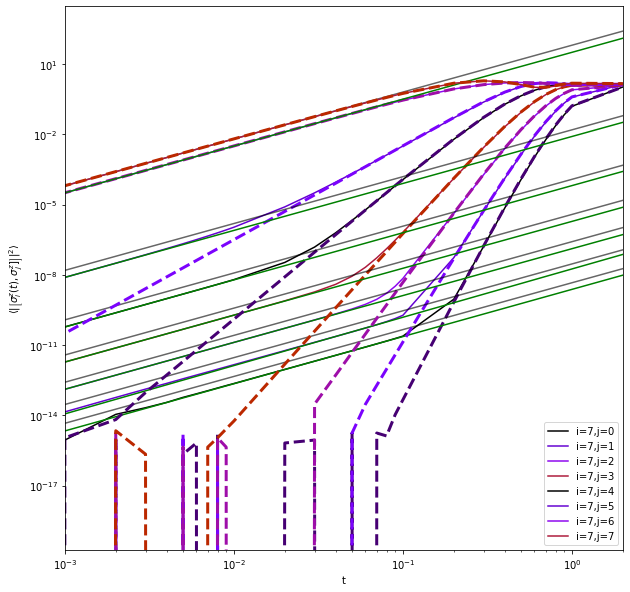

In [202]:
idh = 0
popt = []
perr = []
tfitmax = [35,35,25,25,25,20,25]
tfitmin = [20,20,20,15,15,15,15]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,7):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],res[idh][tfitmin[j]:tfitmax[j],j]*(7-j)**12)
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))


NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax.set_xscale("log")
ax.set_yscale("log")
for j in range(0,N//2):
    ax.loglog(T[1:],res[idh][1:,j],label="i={},j={}".format(N//2-1,j))
    ax.loglog(T[tmin[j]:],res_NN[idh][tmin[j]:,j],linestyle="--",linewidth=3)
    if j!=N//2-1:
        ax.plot(T[tmin[j]:],(8*np.array(T[tmin[j]:])/np.abs(7-j)**6)**2,c="black",alpha=0.6)
    if j !=N//2-1:
        ax.plot(T[1:],model(T[1:],*(popt[j]))/(7-j)**12,color='green')
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_xlim(1e-3,2)
#ax.set_ylim(1e-16,1e-10)
plt.show()

In [199]:
for i in range(0,len(popt)):
    print(popt[i][0]**0.5,popt[i][1]/2)

5.778998498590666 1.007251402183329
6.254435566267789 1.0313080125147944
5.668046515530492 1.0003591314593114
5.684413156175033 1.0008499909148376
5.875066142115204 1.00623387005842
5.767713769870893 1.002667130938157
5.6399361216287645 0.9997948825861075


## other h

h=11


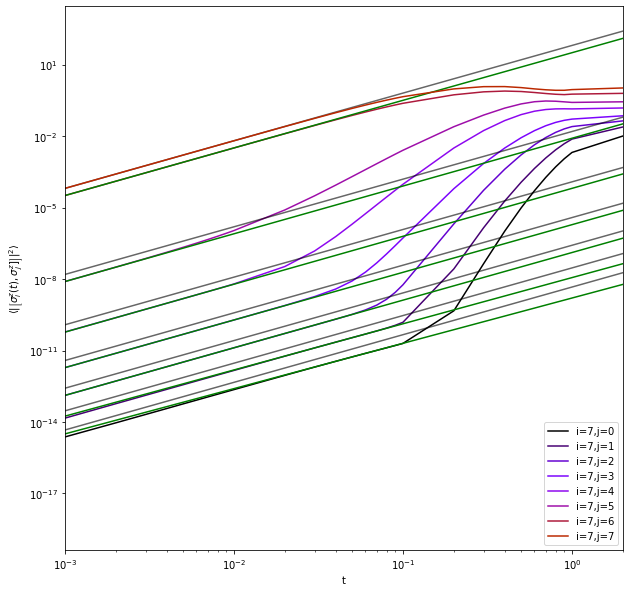

In [206]:
idh = 10
print("h={}".format(h[idh]))
popt = []
perr = []
tfitmax = [35,35,25,25,25,20,25]
tfitmin = [20,20,20,15,15,15,15]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,7):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],res[idh][tfitmin[j]:tfitmax[j],j]*(7-j)**12)
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))


NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.loglog(T[1:],res[idh][1:,j],label="i={},j={}".format(N//2-1,j))
    #ax.loglog(T[tmin[j]:],res_NN[idh][tmin[j]:,j],linestyle="--",linewidth=3)
    if j!=N//2-1:
        ax.plot(T[tmin[j]:],(8*np.array(T[tmin[j]:])/np.abs(7-j)**6)**2,c="black",alpha=0.6)
    if j !=N//2-1:
        ax.plot(T[1:],model(T[1:],*(popt[j]))/(7-j)**12,color='green')

    #ax.errorbar(T[1:],res[idh][1:,j],label="i={},j={}".format(N//2,j),yerr = res_err[idh][1:,j]/np.sqrt(100))
    #ax.errorbar(T[1:],res_NN[idh][1:,j],linestyle="--",linewidth=3,yerr=res_err_NN[idh][1:,j]/np.sqrt(100))
    #if j < 4:
    #    ax.plot(T[1:],model(T[1:],*(popt[j])),color='black')
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_xlim(1e-3,2)
#ax.set_ylim(1e-16,1e-10)
plt.show()

In [53]:
res[idh][:,0]

array([-4.44089210e-16, -7.39408534e-16, -6.52811138e-16, -4.64073224e-16,
       -4.77395901e-16, -3.41948692e-16, -4.41868764e-16, -2.53130850e-16,
       -3.66373598e-16, -4.88498131e-16, -3.17523785e-16, -3.70814490e-16,
       -4.13002965e-16, -9.54791801e-17,  1.99840144e-16,  2.73114864e-16,
        6.10622664e-16,  9.37028233e-16,  1.38555833e-15,  1.82076576e-15,
        8.81517082e-15,  2.03614903e-14,  3.64619446e-14,  5.73296965e-14,
        8.26205770e-14,  1.12803100e-13,  1.47388768e-13,  1.86703986e-13,
        2.30500063e-13,  9.22490972e-13,  2.07430295e-12,  3.68564956e-12,
        5.76086956e-12,  8.31387625e-12,  1.13728871e-11,  1.49909063e-11,
        1.92581351e-11,  2.43264608e-11,  9.32365647e-10,  1.67056889e-07,
        7.11930032e-06,  1.17138295e-04,  1.02255061e-03,  5.63840557e-03,
        2.17833752e-02,  6.30483561e-02,  1.43383814e-01,  9.20171838e-01])